# Create predictions and graph resultant time series

Using M5 data held in BQ, do a number of simple t.s estimations on sales and then plot outputs.

In [3]:
%load_ext google.cloud.bigquery
import numpy as np # linear algebra
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go

from fbprophet import Prophet

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [4]:
%%bigquery df_sales_store_CA_1
-- select sales from one store
select 
*
from
sales_train_evaluation.sales_train_evaluation a
where a.store_id = 'CA_1';

In [5]:
df_sales_store_CA_1.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
4,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0


In [6]:
rms_guess = []
rms_prophet = []
rms_croston = []
rms_croston_tsb = []

PREDICT_DAYS = 28

# just look at one item row
row = df_sales_store_CA_1.iloc[0:1,:]
row

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1


Unpivot the date columns

In [7]:
df_row = pd.DataFrame(row)
df_item = pd.melt(
    df_row,
    id_vars=[
        'id',
        'item_id',
        'dept_id',
        'cat_id',
        'store_id',
        'state_id'
    ],
    var_name='d',
    value_name='sold'
).dropna()

df_item

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0
2,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0
3,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0
4,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0
...,...,...,...,...,...,...,...,...
1936,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1937,0
1937,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1938,3
1938,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1939,3
1939,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1940,0


In [8]:
%%bigquery df_calendar
SELECT date,wm_yr_wk,weekday,wday,month,year,d
FROM `kaggle-covid.calendar.calendar`;

Convert the date codes in the item row to dates by merging with the calendar

In [9]:
df_item = pd.merge(df_item, df_calendar, on='d', how='left')
df_item.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,weekday,wday,month,year
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011
1,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,2,1,2011
2,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0,2011-01-31,11101,Monday,3,1,2011
3,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0,2011-02-01,11101,Tuesday,4,2,2011
4,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0,2011-02-02,11101,Wednesday,5,2,2011


In [10]:
df_item.shape

(1941, 14)

In [11]:
df_item['date'] = pd.to_datetime(df_item['date'], errors='coerce')

For time series estimation we only need date and target variable but we will keep identifier (id) as well for summarising.

In [12]:
df_train = df_item[['date', 'sold', 'id']]
df_train.columns = ["ds", "y", 'id']

# select the training range of dates 
#df_train.iloc[0:1913, :2 ]

# set up data frame to predict into
df_predict = df_train.iloc[1913: , 0:1 ]
df_predict

m = Prophet(daily_seasonality=True)
m.fit(df_train.iloc[0:1913, :2 ])

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [13]:
df_forecast = m.predict(df_predict)

df_forecast['yhat_ceil'] = np.floor(df_forecast['yhat'])
df_forecast['yhat_floor'] = np.floor(df_forecast['yhat'])
df_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper', 'yhat_floor', 'yhat_ceil']]

,ds,yhat,yhat_lower,yhat_upper,yhat_floor,yhat_ceil
0,2016-04-25,0.762951,-0.028089,1.528441,0.0,0.0
1,2016-04-26,0.823022,0.055636,1.575195,0.0,0.0
2,2016-04-27,0.707239,-0.077042,1.503484,0.0,0.0
3,2016-04-28,0.697490,-0.068257,1.453089,0.0,0.0
4,2016-04-29,0.749813,-0.028536,1.522275,0.0,0.0
5,2016-04-30,0.896919,0.092653,1.665972,0.0,0.0
6,2016-05-01,0.773520,-0.062065,1.579674,0.0,0.0
7,2016-05-02,0.721987,0.001912,1.510062,0.0,0.0
8,2016-05-03,0.780765,0.012113,1.550498,0.0,0.0
9,2016-05-04,0.663588,-0.139549,1.415820,0.0,0.0


Actual 28 day sales numbers from evaluation set

In [14]:
# test data: select actual sales figures for the predicted date range
df_actuals = df_train.iloc[1913: , : ]

rms_prophet.append(sqrt(mean_squared_error(df_actuals['y'].astype('int32'), df_forecast['yhat'])))

For comparison: take a naive guess that previous month's sales would be the predicted month's sales

In [15]:
df_guess_last_month = df_train.iloc[1885:1913 , :2 ]

In [16]:
rms_guess.append(sqrt(mean_squared_error(df_actuals['y'].astype('int32'), df_guess_last_month['y'])))

## Intermittent Demand Time series forecasting

Using Croston and Croston TSB

In [17]:
def Croston(ts,extra_periods=1,alpha=0.4):
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), periodicity(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    q = 1 #periods since last demand observation
    
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1 + first_occurence
    f[0] = a[0]/p[0]
    # Create all the t+1 forecasts
    for t in range(0,cols):        
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = alpha*q + (1-alpha)*p[t]
            f[t+1] = a[t+1]/p[t+1]
            q = 1           
        else:
            a[t+1] = a[t]
            p[t+1] = p[t]
            f[t+1] = f[t]
            q += 1
       
    # Future Forecast 
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df


def Croston_TSB(ts,extra_periods=1,alpha=0.4,beta=0.4):
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), probability(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1/(1 + first_occurence)
    f[0] = p[0]*a[0]
                 
    # Create all the t+1 forecasts
    for t in range(0,cols): 
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = beta*(1) + (1-beta)*p[t]  
        else:
            a[t+1] = a[t]
            p[t+1] = (1-beta)*p[t]       
        f[t+1] = p[t+1]*a[t+1]
        
    # Future Forecast
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

In [18]:
df_croston = Croston(df_train.iloc[0:1913, 1:2 ], extra_periods=28)

df_croston_tsb = Croston_TSB(df_train.iloc[0:1913, 1:2 ], extra_periods=28)

In [19]:
rms_croston.append(sqrt(mean_squared_error(df_actuals['y'].astype('int32'), df_croston.iloc[1913: , 1 ])))
rms_croston_tsb.append(sqrt(mean_squared_error(df_actuals['y'].astype('int32'), df_croston_tsb.iloc[1913: , 1 ])))

In [20]:
print("Prophet error...")
print(sum(rms_prophet))
print("Guess error..")
print(sum(rms_guess))
print("Croston  error..")
print(sum(rms_croston))
print("Croston TSB error..")
print(sum(rms_croston_tsb))

Prophet error...
1.4573484899751152
Guess error..
1.6690459207925603
Croston  error..
1.398018709592335
Croston TSB error..
1.3911929782009134


In [21]:
df_actuals = df_actuals.reset_index()

df_summary = df_actuals[['id','ds', 'y']]
df_summary.columns = ['id', 'date', 'actual'] 

df_summary.head()


,id,date,actual
0,HOBBIES_1_001_CA_1_evaluation,2016-04-25,0
1,HOBBIES_1_001_CA_1_evaluation,2016-04-26,0
2,HOBBIES_1_001_CA_1_evaluation,2016-04-27,0
3,HOBBIES_1_001_CA_1_evaluation,2016-04-28,2
4,HOBBIES_1_001_CA_1_evaluation,2016-04-29,0


In [22]:
df_croston_tsb.shape

(1941, 5)

In [26]:
df_croston_tsb[df_croston_tsb['Demand'] > 0].head()

,Demand,Forecast,Period,Level,Error
901,1.0,1.442348e-203,1.442348e-203,1.000,1.000000
916,2.0,3.134567e-04,3.134567e-04,1.000,1.999687
918,1.0,3.361580e-01,2.401128e-01,1.400,0.663842
919,1.0,6.746440e-01,5.440677e-01,1.240,0.325356
925,1.0,6.462230e-02,5.648802e-02,1.144,0.935378


In [28]:
df_croston_tsb = df_croston_tsb.join(df_calendar, how='left')
#df_croston_tsb = pd.merge(df_croston_tsb, df_calendar, on='d', how='left')

In [29]:
df_croston_tsb.head()

,Demand,Forecast,Period,Level,Error,date,wm_yr_wk,weekday,wday,month,year,d
0,0.0,0.001109,0.001109,1.0,-0.001109,2011-01-29,11101,Saturday,1,1,2011,d_1
1,0.0,0.000665,0.000665,1.0,-0.000665,2011-02-19,11104,Saturday,1,2,2011,d_22
2,0.0,0.000399,0.000399,1.0,-0.000399,2011-02-26,11105,Saturday,1,2,2011,d_29
3,0.0,0.000239,0.000239,1.0,-0.000239,2011-03-19,11108,Saturday,1,3,2011,d_50
4,0.0,0.000144,0.000144,1.0,-0.000144,2011-03-26,11109,Saturday,1,3,2011,d_57


In [30]:
df_train.head()

,ds,y,id
0,2011-01-29,0,HOBBIES_1_001_CA_1_evaluation
1,2011-01-30,0,HOBBIES_1_001_CA_1_evaluation
2,2011-01-31,0,HOBBIES_1_001_CA_1_evaluation
3,2011-02-01,0,HOBBIES_1_001_CA_1_evaluation
4,2011-02-02,0,HOBBIES_1_001_CA_1_evaluation


In [24]:
df_train.shape

(1941, 3)

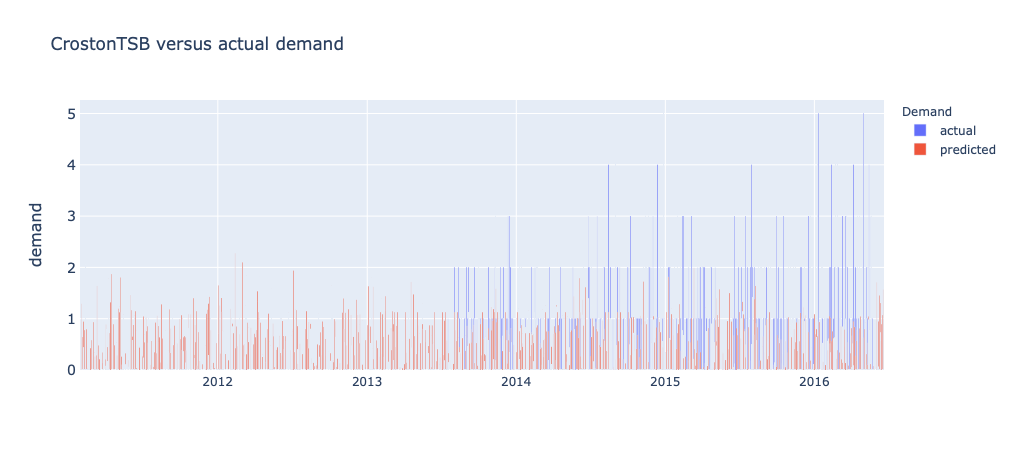

In [33]:
fig = go.Figure(data=[
    go.Bar(name='actual', x=df_train['ds'], y=df_train['y']),
    go.Bar(name='predicted', x=df_croston_tsb['date'], y=df_croston_tsb['Forecast'])
])
# Change the bar mode
fig.update_layout(
    barmode='group',
    title='CrostonTSB versus actual demand',
    legend_title_text = "Demand",
    yaxis=dict(
        title='demand',
        titlefont_size=16,
        tickfont_size=14,
    ))
fig.show()